In [14]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/Users/weidanwu/Documents/MachineLearning/Code/FeedForward/FeedForwardNetwork/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

('Train data shape: ', (49000, 32, 32, 3))
('Train labels shape: ', (49000,))
('Validation data shape: ', (1000, 32, 32, 3))
('Validation labels shape: ', (1000,))
('Test data shape: ', (10000, 32, 32, 3))
('Test labels shape: ', (10000,))


In [16]:
tf.reset_default_graph()

height = 32
width = 32
channels = 3
n_inputs = height * width

n_layers = 3

conv_fmaps = [64, 128, 32]
conv_ksizes = [3, 3, 3]
conv_strides = [1, 1, 1]
conv_paddings = ["SAME", "SAME", "SAME"]
pooling_size = [2, 2]
pooling_stride = 2

n_fc1 = 64
n_outputs = 10

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
    y = tf.placeholder(tf.int64, shape=[None], name="y")
    is_training = tf.placeholder(tf.bool)

convs = []
pools = []
batches = []

for i in np.arange(n_layers):
    conv_input = (X if i == 0 else pools[i-1])
    convs.append(
        tf.layers.conv2d(conv_input, filters = conv_fmaps[i], kernel_size = conv_ksizes[i],
                         strides = conv_strides[i], padding = conv_paddings[i], activation = tf.nn.relu,
                         kernel_regularizer = tf.contrib.layers.l1_l2_regularizer(scale_l1 = 0.4, scale_l2 = 0.2)))
    pools.append(tf.layers.max_pooling2d(inputs = convs[i], pool_size = pooling_size, strides = pooling_stride))
    # batches.append(tf.layers.batch_normalization(pools[i], training = is_training))

conv_output = tf.layers.dropout(pools[-1], rate = 0, training = is_training)
flat = tf.reshape(conv_output,
                  shape=[-1, conv_fmaps[n_layers - 1] * (height / (pooling_stride**n_layers))
                         * (width / (pooling_stride**n_layers))])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    y_out = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(y_out, name="Y_proba")
    
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_out, labels=y)
mean_loss = tf.reduce_mean(xentropy)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)


Training
Iteration 0: with minibatch training loss = 15.3 and accuracy of 0.078
Iteration 100: with minibatch training loss = 2.01 and accuracy of 0.3
Iteration 200: with minibatch training loss = 2.01 and accuracy of 0.22
Iteration 300: with minibatch training loss = 1.62 and accuracy of 0.42
Iteration 400: with minibatch training loss = 1.64 and accuracy of 0.34
Iteration 500: with minibatch training loss = 1.65 and accuracy of 0.3
Iteration 600: with minibatch training loss = 1.52 and accuracy of 0.5
Iteration 700: with minibatch training loss = 1.42 and accuracy of 0.5
Epoch 1, Overall loss = 1.86 and accuracy of 0.362


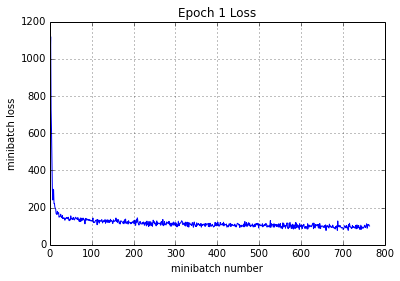

Iteration 800: with minibatch training loss = 1.46 and accuracy of 0.47
Iteration 900: with minibatch training loss = 1.4 and accuracy of 0.53
Iteration 1000: with minibatch training loss = 1.63 and accuracy of 0.42
Iteration 1100: with minibatch training loss = 1.33 and accuracy of 0.52
Iteration 1200: with minibatch training loss = 1.46 and accuracy of 0.44
Iteration 1300: with minibatch training loss = 1.5 and accuracy of 0.48
Iteration 1400: with minibatch training loss = 1.29 and accuracy of 0.56
Iteration 1500: with minibatch training loss = 1.06 and accuracy of 0.66
Epoch 2, Overall loss = 1.34 and accuracy of 0.522


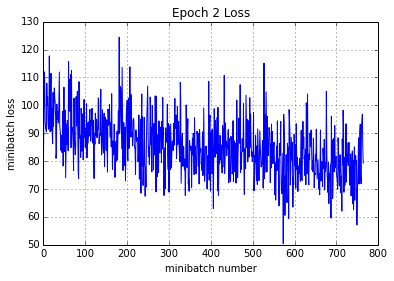

Iteration 1600: with minibatch training loss = 1.16 and accuracy of 0.59
Iteration 1700: with minibatch training loss = 1.18 and accuracy of 0.59
Iteration 1800: with minibatch training loss = 1.32 and accuracy of 0.64
Iteration 1900: with minibatch training loss = 1.16 and accuracy of 0.56
Iteration 2000: with minibatch training loss = 1.28 and accuracy of 0.56
Iteration 2100: with minibatch training loss = 1.05 and accuracy of 0.64
Iteration 2200: with minibatch training loss = 0.984 and accuracy of 0.66
Epoch 3, Overall loss = 1.13 and accuracy of 0.596


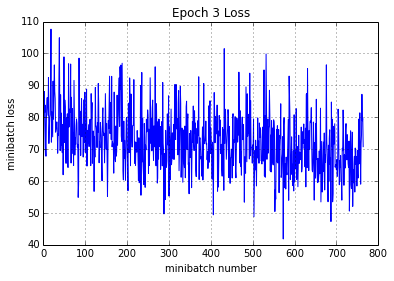

Iteration 2300: with minibatch training loss = 1.02 and accuracy of 0.73
Iteration 2400: with minibatch training loss = 0.976 and accuracy of 0.58
Iteration 2500: with minibatch training loss = 1.02 and accuracy of 0.64
Iteration 2600: with minibatch training loss = 1.14 and accuracy of 0.62
Iteration 2700: with minibatch training loss = 0.823 and accuracy of 0.73
Iteration 2800: with minibatch training loss = 1.02 and accuracy of 0.67
Iteration 2900: with minibatch training loss = 0.809 and accuracy of 0.75
Iteration 3000: with minibatch training loss = 1.11 and accuracy of 0.62
Epoch 4, Overall loss = 1 and accuracy of 0.648


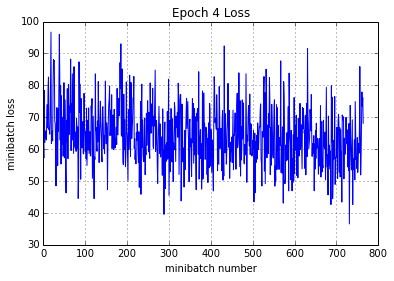

Iteration 3100: with minibatch training loss = 0.695 and accuracy of 0.78
Iteration 3200: with minibatch training loss = 0.837 and accuracy of 0.69
Iteration 3300: with minibatch training loss = 0.77 and accuracy of 0.72
Iteration 3400: with minibatch training loss = 0.944 and accuracy of 0.62
Iteration 3500: with minibatch training loss = 0.985 and accuracy of 0.62
Iteration 3600: with minibatch training loss = 1.16 and accuracy of 0.61
Iteration 3700: with minibatch training loss = 1.06 and accuracy of 0.62
Iteration 3800: with minibatch training loss = 0.878 and accuracy of 0.69
Epoch 5, Overall loss = 0.909 and accuracy of 0.681


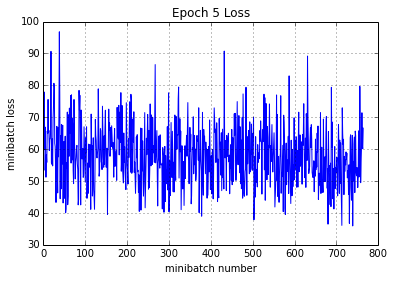

Iteration 3900: with minibatch training loss = 0.844 and accuracy of 0.7
Iteration 4000: with minibatch training loss = 0.617 and accuracy of 0.75
Iteration 4100: with minibatch training loss = 0.758 and accuracy of 0.73
Iteration 4200: with minibatch training loss = 0.886 and accuracy of 0.69
Iteration 4300: with minibatch training loss = 0.924 and accuracy of 0.73
Iteration 4400: with minibatch training loss = 0.925 and accuracy of 0.69
Iteration 4500: with minibatch training loss = 0.942 and accuracy of 0.64
Epoch 6, Overall loss = 0.836 and accuracy of 0.707


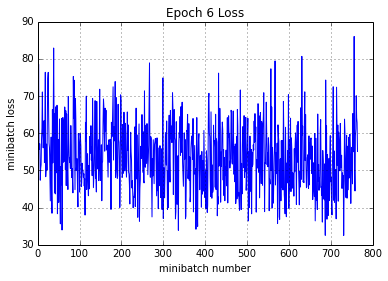

Iteration 4600: with minibatch training loss = 0.844 and accuracy of 0.7
Iteration 4700: with minibatch training loss = 0.719 and accuracy of 0.77
Iteration 4800: with minibatch training loss = 0.984 and accuracy of 0.64
Iteration 4900: with minibatch training loss = 0.566 and accuracy of 0.83
Iteration 5000: with minibatch training loss = 0.966 and accuracy of 0.66
Iteration 5100: with minibatch training loss = 0.886 and accuracy of 0.67
Iteration 5200: with minibatch training loss = 0.563 and accuracy of 0.78
Iteration 5300: with minibatch training loss = 0.655 and accuracy of 0.75
Epoch 7, Overall loss = 0.774 and accuracy of 0.729


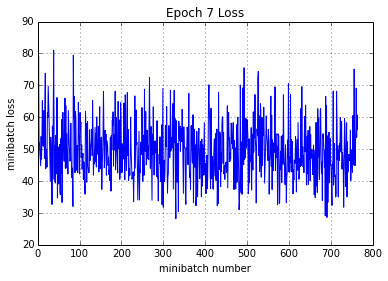

Iteration 5400: with minibatch training loss = 0.645 and accuracy of 0.73
Iteration 5500: with minibatch training loss = 0.756 and accuracy of 0.72
Iteration 5600: with minibatch training loss = 0.606 and accuracy of 0.7
Iteration 5700: with minibatch training loss = 0.919 and accuracy of 0.69
Iteration 5800: with minibatch training loss = 0.674 and accuracy of 0.73
Iteration 5900: with minibatch training loss = 0.857 and accuracy of 0.7
Iteration 6000: with minibatch training loss = 0.537 and accuracy of 0.81
Iteration 6100: with minibatch training loss = 0.781 and accuracy of 0.73
Epoch 8, Overall loss = 0.714 and accuracy of 0.751


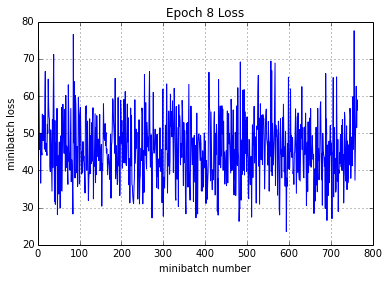

Iteration 6200: with minibatch training loss = 0.555 and accuracy of 0.83
Iteration 6300: with minibatch training loss = 0.955 and accuracy of 0.67
Iteration 6400: with minibatch training loss = 0.765 and accuracy of 0.7
Iteration 6500: with minibatch training loss = 0.734 and accuracy of 0.73
Iteration 6600: with minibatch training loss = 0.694 and accuracy of 0.78
Iteration 6700: with minibatch training loss = 0.776 and accuracy of 0.72
Iteration 6800: with minibatch training loss = 0.313 and accuracy of 0.92
Epoch 9, Overall loss = 0.669 and accuracy of 0.765


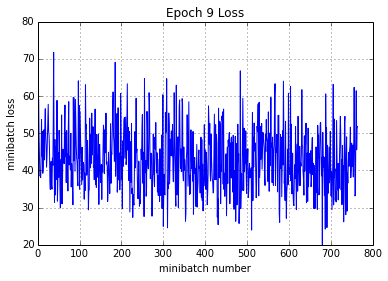

Iteration 6900: with minibatch training loss = 0.619 and accuracy of 0.84
Iteration 7000: with minibatch training loss = 0.772 and accuracy of 0.69
Iteration 7100: with minibatch training loss = 0.664 and accuracy of 0.73
Iteration 7200: with minibatch training loss = 0.602 and accuracy of 0.81
Iteration 7300: with minibatch training loss = 0.607 and accuracy of 0.78
Iteration 7400: with minibatch training loss = 0.698 and accuracy of 0.81
Iteration 7500: with minibatch training loss = 0.729 and accuracy of 0.75
Iteration 7600: with minibatch training loss = 0.678 and accuracy of 0.75
Epoch 10, Overall loss = 0.631 and accuracy of 0.777


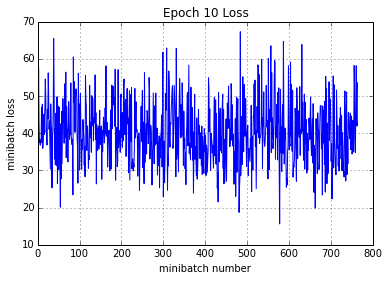

Validation
Epoch 1, Overall loss = 1.02 and accuracy of 0.642


In [17]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=10, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)*1.0/actual_batch_size))
            iter_cnt += 1
        total_correct = correct*1.0/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
        # print('Test')
        # run_model(sess, y_out, mean_loss, X_test, y_test, 1, 64)

In [ ]:

conv1 = tf.layers.conv2d(X, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
                         # kernel_regularizer = tf.contrib.layers.l1_l2_regularizer(scale_l1 = 0, scale_l2 = 0))

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

# batch1 = tf.layers.batch_normalization(pool1, training = is_training)
# batch1_flat = tf.reshape(batch1, shape = [-1, pool1_fmaps * 16 * 16])

conv2 = tf.layers.conv2d(pool1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2") 
                         # kernel_regularizer = tf.contrib.layers.l1_l2_regularizer(scale_l1 = 0, scale_l2 = 0))

pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
# batch2 = tf.layers.batch_normalization(pool2, training = is_training)

pool2_flat = tf.reshape(pool2, shape=[-1, pool2_fmaps * 8 * 8])